# Análisis Estadístico Intermedio con Pandas DataFrame
Este notebook demuestra cómo aplicar conceptos estadísticos fundamentales utilizando un DataFrame de Pandas.

## 1. Importación de Librerías
Importamos las librerías necesarias para el análisis.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

## 2. Creación del DataFrame
Vamos a crear un DataFrame simulado con datos de empleados para nuestros ejemplos. Contendrá:
- `edad`: Distribuida normalmente.
- `salario`: Con una distribución sesgada a la derecha (más salarios bajos, pocos muy altos) y un outlier.
- `antiguedad_meses`: Relacionada linealmente con la edad.
- `satisfaccion_score`: Relacionada de forma no lineal (monotónica) con el salario.

In [2]:
np.random.seed(42)
n_empleados = 100
edad = np.random.normal(loc=40, scale=8, size=n_empleados).astype(int)
salario = stats.gamma.rvs(a=5, scale=10000, size=n_empleados)
salario[10] = 350000 # Añadimos un outlier
antiguedad_meses = (edad * 12 * 0.4 + np.random.normal(0, 24, n_empleados)).astype(int)
satisfaccion_score = np.log(salario) * 1.5 + np.random.normal(0, 0.5, n_empleados)
satisfaccion_score = np.clip(satisfaccion_score, 1, 10) # Acotamos el score entre 1 y 10

df = pd.DataFrame({
    'edad': edad,
    'salario': salario,
    'antiguedad_meses': antiguedad_meses,
    'satisfaccion_score': satisfaccion_score
})

print("Primeras 5 filas del DataFrame:")
display(df.head())
print("Información general del DataFrame:")
df.info()

Primeras 5 filas del DataFrame:


,edad,salario,antiguedad_meses,satisfaccion_score
0,43,22282.625223,245,10.0
1,38,38156.736524,148,10.0
2,45,43268.488033,205,10.0
3,52,55950.662525,252,10.0
4,38,52454.427343,216,10.0


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   edad                100 non-null    int64  
 1   salario             100 non-null    float64
 2   antiguedad_meses    100 non-null    int64  
 3   satisfaccion_score  100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


## 3. Estadísticas Descriptivas
Pandas ofrece el método `.describe()` que calcula un resumen de las estadísticas más importantes para todas las columnas numéricas.

In [3]:
df.describe()

,edad,salario,antiguedad_meses,satisfaccion_score
count,100.000000,100.000000,100.000000,100.0
mean,38.660000,54047.465977,186.910000,10.0
std,7.224006,39575.037108,39.026822,0.0
min,19.000000,5828.490370,71.000000,10.0
25%,35.000000,32693.946331,163.000000,10.0
50%,38.500000,49115.211878,189.000000,10.0
75%,43.000000,63168.876821,214.500000,10.0
max,54.000000,350000.000000,277.000000,10.0


### Media, Mediana y Moda (por columna)
Aunque `.describe()` ya nos da la media y la mediana (50%), podemos calcularlas individualmente. La diferencia entre media y mediana en la columna `salario` es un claro indicador del efecto del outlier y el sesgo de los datos.

In [4]:
print(f"Media del salario: ${df['salario'].mean():,.2f}")
print(f"Mediana del salario: ${df['salario'].median():,.2f}")
print(f"Moda del salario: ${df['salario'].mode()[0]:,.2f}")

Media del salario: $54,047.47
Mediana del salario: $49,115.21
Moda del salario: $5,828.49


### Varianza y Desviación Estándar

In [5]:
print(f"Varianza del salario: {df['salario'].var():,.2f}")
print(f"Desviación estándar del salario: {df['salario'].std():,.2f}")

Varianza del salario: 1,566,183,562.14
Desviación estándar del salario: 39,575.04


## 4. Test de Normalidad
Evaluaremos si las columnas `edad` y `salario` siguen una distribución normal. La hipótesis nula (H0) es que los datos son normales. Si el p-value < 0.05, rechazamos H0.

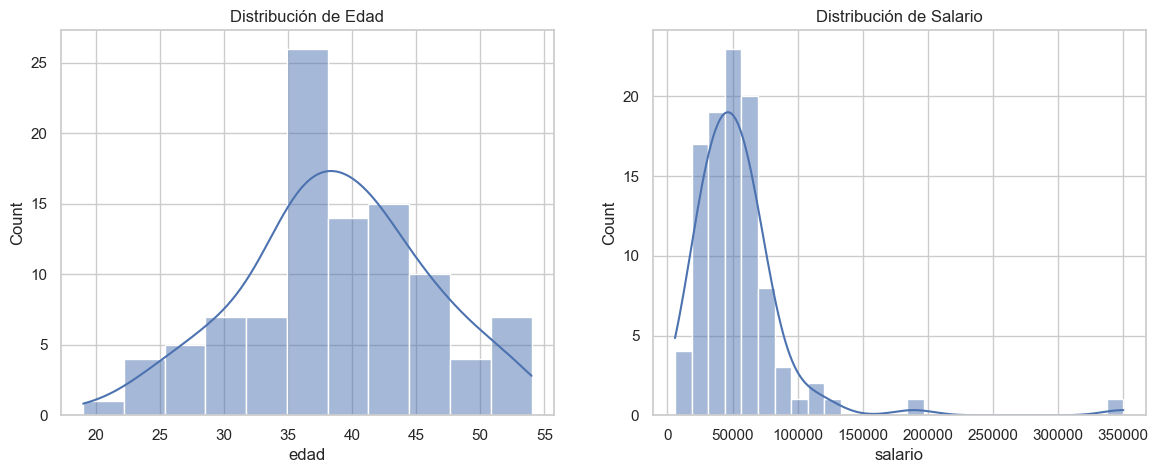

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['edad'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Edad')
sns.histplot(df['salario'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Salario')
plt.show()

In [9]:
def check_normality(data, name=''):
    shapiro_stat, shapiro_p = stats.shapiro(data)
    k2_stat, k2_p = stats.normaltest(data)
    print(f'Resultados de normalidad para {name}:')
    print(f'  Test de Shapiro-Wilk: p-value = {shapiro_p:.4f}')
    if shapiro_p > 0.05:
        print('    Conclusión: Los datos parecen normales.')
    else:
        print('    Conclusión: Los datos NO parecen normales.')
        print(f'  Test de DAgostino y Pearson (K^2): p-value = {k2_p:.4f}')
    if k2_p > 0.05:
        print('    Conclusión: Los datos parecen normales.')
    else:
        print('    Conclusión: Los datos NO parecen normales.')

check_normality(df['edad'], name='Edad')
check_normality(df['salario'], name='Salario')

Resultados de normalidad para Edad:
  Test de Shapiro-Wilk: p-value = 0.5183
    Conclusión: Los datos parecen normales.
    Conclusión: Los datos parecen normales.
Resultados de normalidad para Salario:
  Test de Shapiro-Wilk: p-value = 0.0000
    Conclusión: Los datos NO parecen normales.
  Test de DAgostino y Pearson (K^2): p-value = 0.0000
    Conclusión: Los datos NO parecen normales.


## 5. Análisis de Correlación
Calcularemos la matriz de correlación para todo el DataFrame usando los tres métodos: Pearson, Spearman y Kendall. Una matriz de calor (heatmap) es ideal para visualizar los resultados.

### Correlación de Pearson (Lineal)
Mide la fuerza de la relación lineal entre variables.

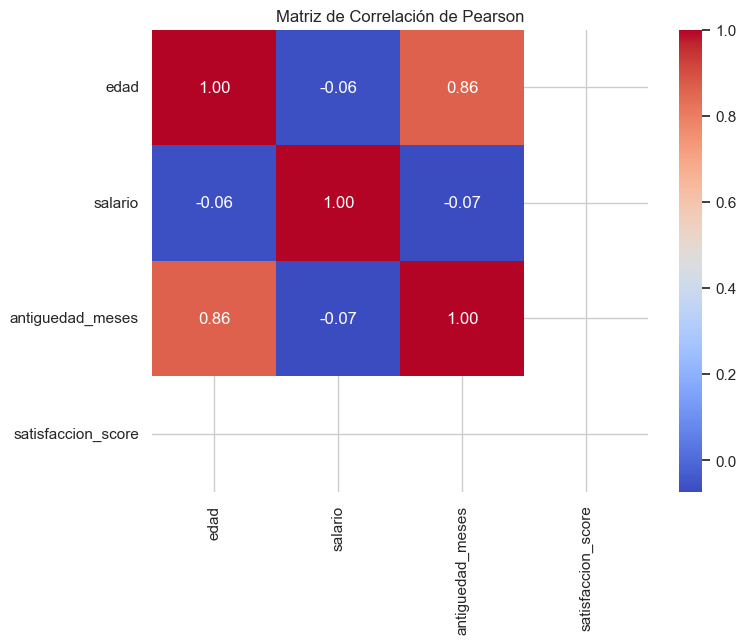

In [10]:
corr_pearson = df.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Pearson')
plt.show()

### Correlación de Spearman (Monotónica)
Mide la fuerza de la relación monotónica (si una variable crece, la otra también, pero no necesariamente a un ritmo constante). Es no paramétrica y robusta a outliers.

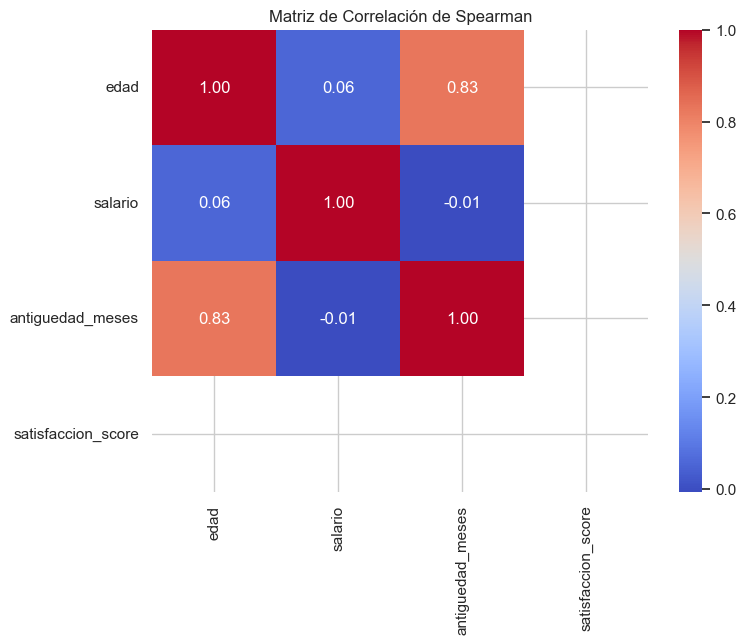

Observa cómo Spearman detecta una correlación más fuerte entre salario y satisfacción que Pearson, ya que la relación es monotónica pero no perfectamente lineal.


In [11]:
corr_spearman = df.corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Spearman')
plt.show()
print('Observa cómo Spearman detecta una correlación más fuerte entre salario y satisfacción que Pearson, ya que la relación es monotónica pero no perfectamente lineal.')

### Correlación Tau de Kendall
Similar a Spearman, es una medida de correlación de rangos no paramétrica.

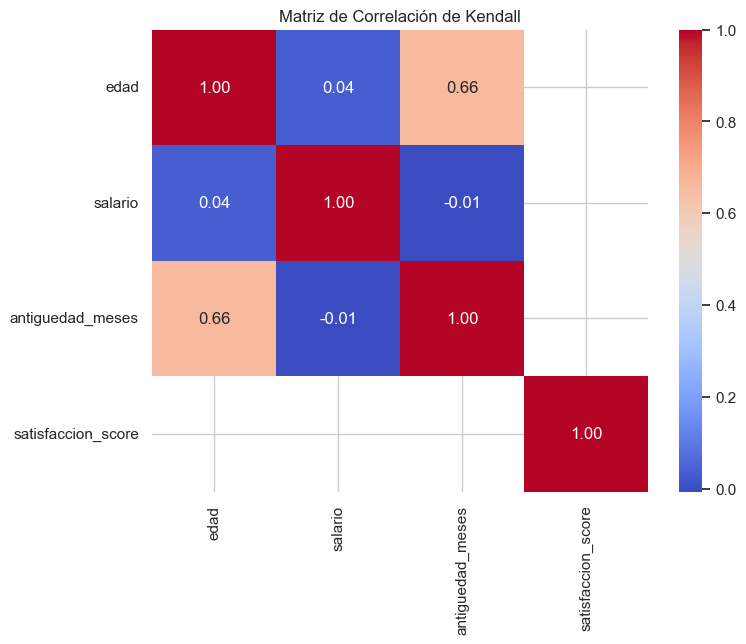

In [12]:
corr_kendall = df.corr(method='kendall')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Kendall')
plt.show()

## 6. Normalización (Escalado Min-Max)
Escalaremos la columna `salario` a un rango entre 0 y 1. Esto es útil para muchos algoritmos de Machine Learning. Crearemos una nueva columna para no sobreescribir la original.

In [13]:
scaler = MinMaxScaler()
# Usamos .values.reshape(-1, 1) o [[]] para darle el formato 2D que el scaler necesita
df['salario_normalizado'] = scaler.fit_transform(df[['salario']])

display(df[['salario', 'salario_normalizado']].describe())

,salario,salario_normalizado
count,100.000000,100.000000
mean,54047.465977,0.140102
std,39575.037108,0.114986
min,5828.490370,0.000000
25%,32693.946331,0.078058
50%,49115.211878,0.125771
75%,63168.876821,0.166604
max,350000.000000,1.000000


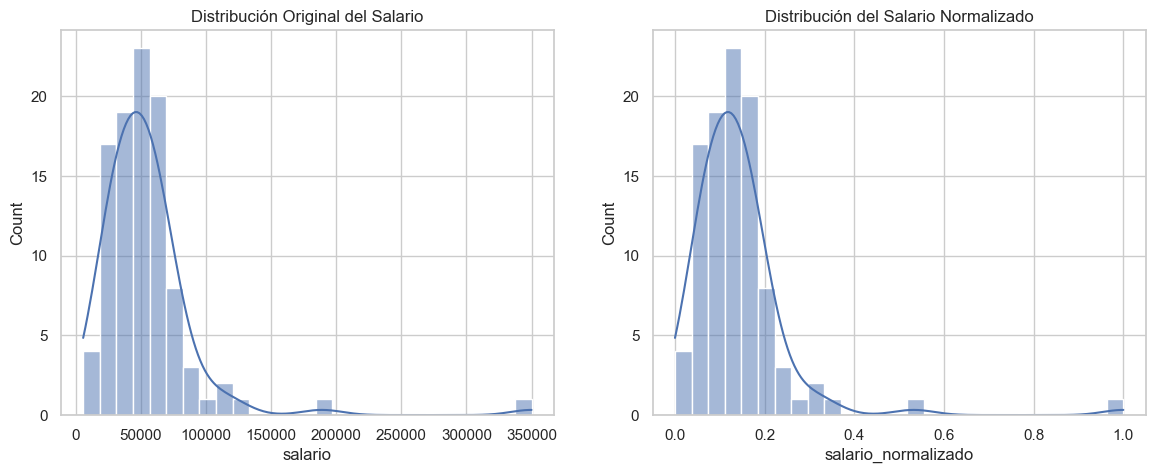

La forma de la distribución es idéntica, solo ha cambiado la escala en el eje X.


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['salario'], kde=True, ax=axes[0])
axes[0].set_title('Distribución Original del Salario')
sns.histplot(df['salario_normalizado'], kde=True, ax=axes[1])
axes[1].set_title('Distribución del Salario Normalizado')
plt.show()
print('La forma de la distribución es idéntica, solo ha cambiado la escala en el eje X.')